# **Computer Vision - Image Classification**

This project will use fine-tuning on an already pretrained Hugging Face  model: [microsoft/swin-tiny-patch4-window7-224](https://huggingface.co/microsoft/swin-tiny-patch4-window7-224) for Fashion Items Classification. 

The aim is to incorporate a randomly initialized classification head onto a pre-trained encoder, and subsequently perform fine-tuning using a labeled dataset.

We will be working on a 'Multiclass Classification' problem, in which, the goal is to predict an appropriate class for a given image, e.g. 'Dog' in the picture below. 


<img src="https://www.mathworks.com/help/examples/nnet/win64/MultilabelImageClassificationUsingDeepLearningExample_01.png" alt="drawing" width="1000"/>

## 1.1. Installs & Connecting to 🤗

In [1]:
!pip install -q datasets transformers==4.28.0

!git config --global credential.helper store
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Your token has been saved in your configured git cred

## 1.2. Imports

In [2]:
import torch
import numpy as np
from datasets import load_dataset, load_metric
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from collections import Counter
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

## 2. Loading data

For this project, I'm going to be using a pre-processed Fashion Items dataset.
Original dataset can be found [here](https://huggingface.co/datasets/ashraq/fashion-product-images-small).

For the image classification task, I am going to focus on the 'subCategory' of the fashion item - that will become the 'label'. Let's inspect closer.

In [3]:
dataset = load_dataset("agestau/preproc-fashion-products")
dataset

  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['subCategory', 'image', 'text'],
        num_rows: 36145
    })
})

## 3.1. Preparing the dataset

The dataset consists of 36,145 records. 

Right now, `dataset` is a 'DatasetDict', which contains one key per split (in this case, only "train" for a training split). So first, let's extract the huggingface dataset from it.

Next, the feature `'text'` will be used on the 'Computer Vision - Image Captioning' task and is unneccessary here, let's drop it.

`'subCategory'` will be used as our label. Let's rename and class encode it so it would have numerical representations of the classes.

In [4]:
ds=dataset["train"]
ds

Dataset({
    features: ['subCategory', 'image', 'text'],
    num_rows: 36145
})

In [6]:
dataset2 = ds.remove_columns(['text'])
dataset2 = dataset2.rename_column("subCategory", "label")
dataset2 = dataset2.class_encode_column("label")
dataset2

Dataset({
    features: ['label', 'image'],
    num_rows: 36145
})

Let's see what are the possible labels:

In [7]:
dataset2.features

{'label': ClassLabel(names=['Bags', 'Belts', 'Bottomwear', 'Dress', 'Eyewear', 'Headwear', 'Jewellery', 'Scarves', 'Shoes', 'Socks', 'Ties', 'Topwear', 'Wallets', 'Watches'], id=None),
 'image': Image(decode=True, id=None)}

An example of a record:

In [20]:
example = dataset2[187]
example

{'label': 8,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F4D20001BA0>}

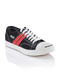

In [21]:
example['image']

In [22]:
example['label']

8

As the labels have now been class encoded, we cannot access it's string values. Let's write a dictionary to make this easier.

In [24]:
labels = dataset2.features["label"].names

label_to_num, num_to_label = dict(), dict()
for i, label in enumerate(labels):
    label_to_num[label] = i
    num_to_label[i] = label

Let's see the label for our example:

In [25]:
num_to_label[8]

'Shoes'

## 3.2. Preparing data for training

Before training, the pictures in the dataset need to be prepared to be fed into the model. Oftenly, this preprocessing consists of:

1. Resizing the pictures: machine learning models train faster on smaller images.
2. Image transformations: Normalizing the color channels which helps center the data, using mean and standard deviation.
3. Data augmentation: applying various transformations to the existing data (flipping, rotating, etc.) to increase the size of the training sample in which case the model will most probably be more robust.

To help with preprocessing, I'll be using `AutoImageProcessor` method from `transformers` and several methods from`torchvision.transforms`


In [ ]:
# Loading the image processor
processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Functions for preprocessing:

In [30]:
# Set up image normalization using mean and standard deviation
normalize = Normalize(mean=processor.image_mean, 
                      std=processor.image_std)
if "height" in processor.size:
    dims = (processor.size["height"], processor.size["width"])
    crop = dims
    max_dims = None
elif "shortest_edge" in processor.size:
    dims = processor.size["shortest_edge"]
    crop = (dims, dims)
    max_dims = processor.size.get("longest_edge")

# Define the training data transformations
train_transforms = Compose(
        [
            RandomResizedCrop(crop),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

# Define the testing/validation data transformations
test_transforms = Compose(
        [
            Resize(dims),
            CenterCrop(crop),
            ToTensor(),
            normalize,
        ]
    )

# Apply train_transforms to preprocess the training batch.
def train_prep(batch):
    batch["pixel_values"] = [train_transforms(pic.convert("RGB")) for pic in batch["image"]]
    return batch
    
# Apply test_transforms to preprocess the testing/validation batch.
def test_prep(batch):
    batch["pixel_values"] = [test_transforms(pic.convert("RGB")) for pic in batch["image"]]
    return batch

Split the data: 90% train and 10% test samples will be used.

In [32]:
# Split the data
splits = dataset2.train_test_split(test_size=0.1)
train_dataset = splits['train']
test_dataset = splits['test']

train_dataset

Dataset({
    features: ['label', 'image'],
    num_rows: 32530
})

Prepare the datasets accordingly:

In [33]:
train_dataset.set_transform(train_prep)
test_dataset.set_transform(test_prep)

Let's look at how a record looks when it's been preprocessed for training:

In [34]:
train_dataset[3]

{'label': 11,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F4D01D426E0>,
 'pixel_values': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.4397, -0.4397, -0.4397,  ...,  2.2489,  2.2489,  2.2489],
          [-0.4397, -0.4397, -0.4397,  ...,  2.2489,  2.2489,  2.2489],
          [-0.4397, -0.4397, -0.4397,  ...,  2.2489,  2.2489,  2.2489]],
 
         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-0.3725, -0.3725, -0.3725,  ...,  2.4286,  2.4286,  2.4286],
          [-0.3725, -0.3725, -0.3725,  ...,  2.4286,  2.4286,  2.4286],
          [-0.3725, -0.3725, -0.3725,  ...,  2.4286,  

##4. Preparing for training

The data has been prepared. 

The pretrained model needs to be downloaded from Hugging Face. 


In [35]:
# I'm using the argument `ignore_mismatched_sizes=True` to make sure the output head is thrown away and replaced by a new, randomly initialized classification head
model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224",label2id=label_to_num,id2label=num_to_label,ignore_mismatched_sizes = True)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation metric will be `accuracy`.

In [36]:
accuracy = load_metric("accuracy")

<ipython-input-36-ef74769317a9>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")


Define training arguments:

In [37]:
args = TrainingArguments(
    "fashion_classification_3",  # Output directory for the trained model
    remove_unused_columns=False,  # Flag to keep unused columns in the input data - these have to stay as they will be used to generate pixel_values 
    evaluation_strategy="epoch",  
    save_strategy="epoch", 
    learning_rate=5e-5,  
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,  # performing a backward pass every 4 batches
    per_device_eval_batch_size=32,  
    num_train_epochs=5,  
    warmup_ratio=0.1,  # Ratio of total training steps used for linear warmup - stabilizes the training process, especially with large-scale models and complex datasets
    logging_steps=10,  
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",  
    push_to_hub=True,  
    hub_model_id="agestau/fashion_classification_3"  
)

In [38]:
# Calculate the accuracy per batch
def compute_accuracy(batch):
    predictions = np.argmax(batch.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=batch.label_ids)

In [41]:
# Collate singular examples into a batch
def collate_to_batches(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Now that we have everything prepared, let's just stick everything into the trainer:

In [42]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_accuracy,
    data_collator=collate_to_batches,
)

## 5. Training

In [ ]:
train_results = trainer.train()

trainer.log_metrics("train", train_results.metrics)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.167000,0.054484,0.982849
1,0.134000,0.042953,0.983679
2,0.136000,0.036274,0.988105
4,0.092900,0.029343,0.989765
4,0.113700,0.026730,0.990318


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/May16_03-51-03_7aa1ab956eaa/events.out.tfevents.1684209085.7aa1ab956eaa.2418.0:   0%|        …

To https://huggingface.co/agestau/fashion_classification_3
   4a50633..3d5d80c  main -> main

   4a50633..3d5d80c  main -> main

To https://huggingface.co/agestau/fashion_classification_3
   3d5d80c..0bdaad4  main -> main

   3d5d80c..0bdaad4  main -> main



***** train metrics *****
  epoch                    =          5.0
  total_flos               = 3763057303GF
  train_loss               =       0.2311
  train_runtime            =   0:41:37.79
  train_samples_per_second =       65.118
  train_steps_per_second   =        0.508


##6. Evaluation

Fine-tuned model metrics:

In [ ]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9903
  eval_loss               =     0.0267
  eval_runtime            = 0:00:22.51
  eval_samples_per_second =    160.544
  eval_steps_per_second   =      5.018


We can also try and do inference on the model using a random image from the net. 

`transformers` offers a `pipeline` model, which is really convenient and easy to use on models that are on the Hugging Face hub. Since this model got pushed there after training, we can leverage from it to generate the prediction. 

Load the image:

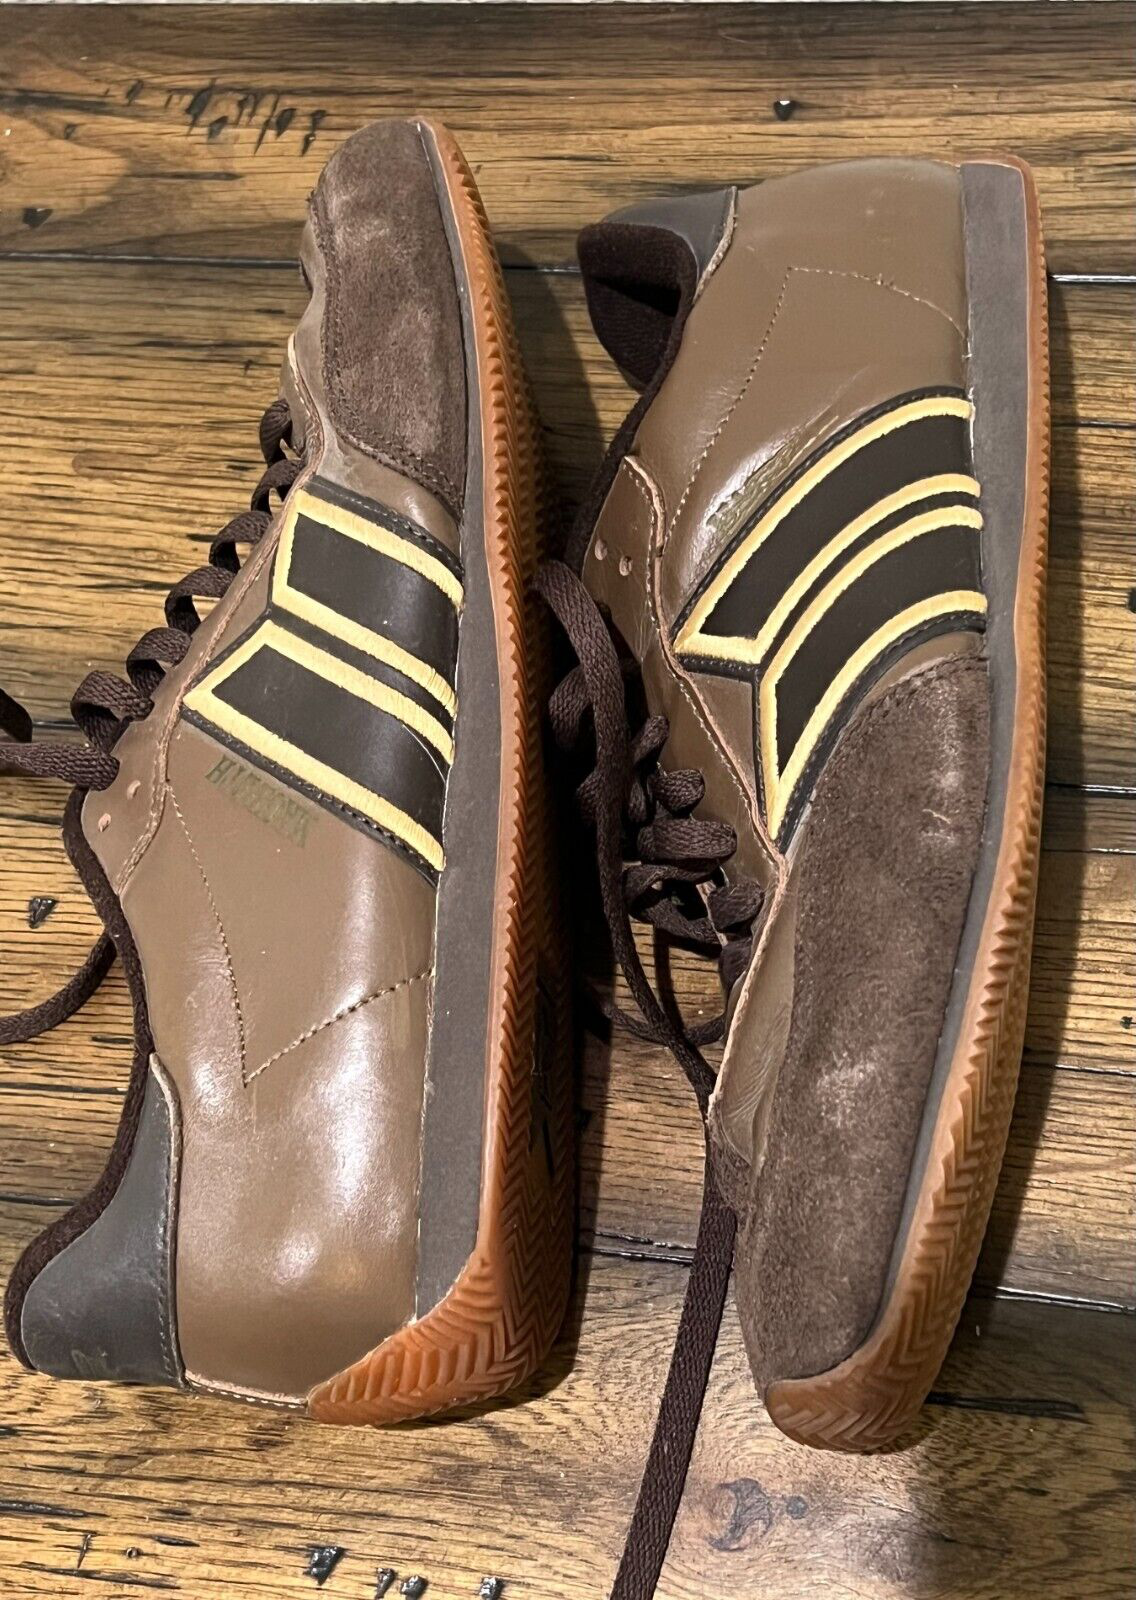

In [ ]:
from PIL import Image
import requests

url = 'https://i.ebayimg.com/images/g/HI4AAOSwDx9kYr9Z/s-l1600.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
pipeline = pipeline("image-classification", "agestau/fashion_classification_3")

For `"image-classification"` tasks, pipeline returns 5 most probable labels and their scores. We can see that the label 'Shoes' got the highest score, which is correct.

In [ ]:
pipeline(image)

[{'score': 0.9064949154853821, 'label': 'Shoes'},
 {'score': 0.07806135714054108, 'label': 'Bags'},
 {'score': 0.004524799529463053, 'label': 'Wallets'},
 {'score': 0.0019646326545625925, 'label': 'Belts'},
 {'score': 0.0018450224306434393, 'label': 'Socks'}]